# Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей.

1. Выберите набор данных (датасет) для решения задачи классификации или регрессии.
2. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
4. Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. Оцените качество модели с помощью подходящих для задачи метрик.
5. Произведите подбор гиперпараметра K с использованием GridSearchCV и RandomizedSearchCV и кросс-валидации, оцените качество оптимальной модели. Используйте не менее двух стратегий кросс-валидации.
6. Сравните метрики качества исходной и оптимальной моделей.

## Описание данных

In [80]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import Dict, Tuple
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve, validation_curve


In [68]:
data = pd.read_csv('milknew.csv', sep=",")
data = data[data.columns]

In [69]:
data.dtypes

pH            float64
Temprature      int64
Taste           int64
Odor            int64
Fat             int64
Turbidity       int64
Colour          int64
Grade          object
dtype: object

In [70]:
data.head

<bound method NDFrame.head of        pH  Temprature  Taste  Odor  Fat   Turbidity  Colour   Grade
0     6.6          35      1     0     1          0     254    high
1     6.6          36      0     1     0          1     253    high
2     8.5          70      1     1     1          1     246     low
3     9.5          34      1     1     0          1     255     low
4     6.6          37      0     0     0          0     255  medium
...   ...         ...    ...   ...   ...        ...     ...     ...
1054  6.7          45      1     1     0          0     247  medium
1055  6.7          38      1     0     1          0     255    high
1056  3.0          40      1     1     1          1     255     low
1057  6.8          43      1     0     1          0     250    high
1058  8.6          55      0     1     1          1     255     low

[1059 rows x 8 columns]>

In [71]:
data.isnull().sum()


pH            0
Temprature    0
Taste         0
Odor          0
Fat           0
Turbidity     0
Colour        0
Grade         0
dtype: int64

In [72]:
data.shape

(1059, 8)

In [73]:
data.describe()


,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour
count,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000
mean,6.630123,44.226629,0.546742,0.432483,0.671388,0.491029,251.840415
std,1.399679,10.098364,0.498046,0.495655,0.469930,0.500156,4.307424
min,3.000000,34.000000,0.000000,0.000000,0.000000,0.000000,240.000000
25%,6.500000,38.000000,0.000000,0.000000,0.000000,0.000000,250.000000
50%,6.700000,41.000000,1.000000,0.000000,1.000000,0.000000,255.000000
75%,6.800000,45.000000,1.000000,1.000000,1.000000,1.000000,255.000000
max,9.500000,90.000000,1.000000,1.000000,1.000000,1.000000,255.000000


## Разделение выборки на обучающую и тестовую

In [82]:
x_train, x_test, y_train, y_test = train_test_split(
    data.drop(["Grade"], axis=1), data["Grade"], test_size=0.5, random_state=1)

In [83]:
x_train.shape, y_train.shape


((529, 7), (529,))

In [84]:
def class_proportions(array: np.ndarray) -> Dict[int, Tuple[int, float]]:
    """
    Вычисляет пропорции классов
    array - массив, содержащий метки классов
    """
    # Получение меток классов и количества меток каждого класса 
    labels, counts = np.unique(array, return_counts=True)
    # Превращаем количество меток в процент их встречаемости
    # делим количество меток каждого класса на общее количество меток
    counts_perc = counts/array.size
    # Теперь sum(counts_perc)==1.0
    # Создаем результирующий словарь,
    # ключом словаря явлется метка класса, 
    # а значением словаря процент встречаемости метки
    res = dict()
    for label, count2 in zip(labels, zip(counts, counts_perc)):
        res[label] = count2
    return res

def print_class_proportions(array: np.ndarray):
    """
    Вывод пропорций классов
    """
    proportions = class_proportions(array)
    if len(proportions)>0:
        print('Метка \t Количество \t Процент встречаемости')
    for i in proportions:
        val, val_perc = proportions[i]
        val_perc_100 = round(val_perc * 100, 2)
        print('{} \t {} \t \t {}%'.format(i, val, val_perc_100))

In [85]:
# Для обучающей выборки
print_class_proportions(y_train)

Метка 	 Количество 	 Процент встречаемости
high 	 130 	 	 24.57%
low 	 208 	 	 39.32%
medium 	 191 	 	 36.11%


In [86]:
# Для тестовой выборки
print_class_proportions(y_test)

Метка 	 Количество 	 Процент встречаемости
high 	 126 	 	 23.77%
low 	 221 	 	 41.7%
medium 	 183 	 	 34.53%


## Метод k-ближайших соседей

In [87]:
cl1_1 = KNeighborsClassifier(n_neighbors=70)
cl1_1.fit(x_train, y_train)
target1_0 = cl1_1.predict(x_train)
target1_1 = cl1_1.predict(x_test)
accuracy_score(y_train, target1_0), accuracy_score(y_test, target1_1)

(0.8015122873345936, 0.769811320754717)

In [89]:
# 5 ближайших соседей
cl1_2 = KNeighborsClassifier(n_neighbors=5)
cl1_2.fit(x_train, y_train)
target1_0 = cl1_2.predict(x_train)
target1_1 = cl1_2.predict(x_test)
accuracy_score(y_train, target1_0), accuracy_score(y_test, target1_1)

(0.994328922495274, 0.9792452830188679)

In [90]:
# 1 ближайший сосед - "условное" переобучение
cl1_2 = KNeighborsClassifier(n_neighbors=1)
cl1_2.fit(x_train, y_train)
target1_0 = cl1_2.predict(x_train)
target1_1 = cl1_2.predict(x_test)
accuracy_score(y_train, target1_0), accuracy_score(y_test, target1_1)

(1.0, 0.9905660377358491)

## Кросс-валидация

### K-fold

In [92]:
kf = KFold(n_splits=5)
scores = cross_val_score(KNeighborsClassifier(n_neighbors=2), 
                         data.drop(["Grade"], axis=1), data["Grade"], scoring='f1_weighted', 
                         cv=kf)
scores

array([0.99059093, 1.        , 0.99057998, 1.        , 0.98110621])

In [93]:
scoring = {'precision': 'precision_weighted', 
           'recall': 'recall_weighted',
           'f1': 'f1_weighted'}

In [94]:
kf = KFold(n_splits=5)
scores = cross_validate(KNeighborsClassifier(n_neighbors=2), 
                        data.drop(["Grade"], axis=1), data["Grade"], scoring=scoring, 
                        cv=kf, return_train_score=True)
scores

{'fit_time': array([0.00346017, 0.00300169, 0.00209284, 0.002774  , 0.00300002]),
 'score_time': array([0.01699901, 0.0110867 , 0.01090741, 0.01133513, 0.01528668]),
 'test_precision': array([0.9908143 , 1.        , 0.99088583, 1.        , 0.98230648]),
 'train_precision': array([0.99766121, 0.99766121, 0.99766222, 0.99766111, 1.        ]),
 'test_recall': array([0.99056604, 1.        , 0.99056604, 1.        , 0.98104265]),
 'train_recall': array([0.99763872, 0.99763872, 0.99763872, 0.99763872, 1.        ]),
 'test_f1': array([0.99059093, 1.        , 0.99057998, 1.        , 0.98110621]),
 'train_f1': array([0.99764043, 0.99764037, 0.99764072, 0.99764036, 1.        ])}

### Repeated K-Fold

In [95]:
kf = RepeatedKFold(n_splits=3, n_repeats=2)
scores = cross_validate(KNeighborsClassifier(n_neighbors=2), 
                        data.drop(["Grade"], axis=1), data["Grade"], scoring=scoring, 
                        cv=kf, return_train_score=True)
scores

{'fit_time': array([0.00190425, 0.00200057, 0.0019834 , 0.00348926, 0.00358248,
        0.00200009]),
 'score_time': array([0.0192368 , 0.01534319, 0.02508163, 0.01976848, 0.01673555,
        0.0150001 ]),
 'test_precision': array([0.99719036, 0.98880255, 0.98881572, 0.99433428, 0.99446018,
        0.99436722]),
 'train_precision': array([0.99720066, 0.99859215, 0.9971981 , 0.99859171, 0.99720047,
        0.9985918 ]),
 'test_recall': array([0.99716714, 0.98866856, 0.98866856, 0.99433428, 0.99433428,
        0.99433428]),
 'train_recall': array([0.99716714, 0.99858357, 0.99716714, 0.99858357, 0.99716714,
        0.99858357]),
 'test_f1': array([0.997168  , 0.98868304, 0.98868656, 0.99433428, 0.99434398,
        0.99433759]),
 'train_f1': array([0.99716995, 0.99858431, 0.99716909, 0.99858421, 0.99716972,
        0.99858421])}

### Leave One Out (LOO)

In [96]:
kf = LeaveOneOut()
scores = cross_validate(KNeighborsClassifier(n_neighbors=2), 
                        data.drop(["Grade"], axis=1), data["Grade"], scoring=scoring, 
                        cv=kf, return_train_score=True)
scores

d:\st\семестр 6\тмо\лр\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\st\семестр 6\тмо\лр\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\st\семестр 6\тмо\лр\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\st\семестр 6\тмо\лр\.venv\Lib\sit

{'fit_time': array([0.00430298, 0.01175213, 0.00300026, ..., 0.00199986, 0.00287151,
        0.00300169]),
 'score_time': array([0.00800037, 0.00400925, 0.00400066, ..., 0.00399899, 0.00401282,
        0.00396013]),
 'test_precision': array([0., 1., 1., ..., 1., 1., 1.]),
 'train_precision': array([0.99812435, 0.99812435, 0.99812429, ..., 0.99812429, 0.99812435,
        0.99812429]),
 'test_recall': array([0., 1., 1., ..., 1., 1., 1.]),
 'train_recall': array([0.99810964, 0.99810964, 0.99810964, ..., 0.99810964, 0.99810964,
        0.99810964]),
 'test_f1': array([0., 1., 1., ..., 1., 1., 1.]),
 'train_f1': array([0.9981108 , 0.9981108 , 0.99811078, ..., 0.99811078, 0.9981108 ,
        0.99811078])}

### Leave P Out (LPO)

In [119]:
kf = LeavePOut(10)
scores = cross_validate(KNeighborsClassifier(n_neighbors=2), 
                        data.drop(["Grade"], axis=1), data["Grade"], scoring=scoring, 
                        cv=kf, return_train_score=True)
scores

KeyboardInterrupt: 

### ShuffleSplit

In [99]:
kf = ShuffleSplit(n_splits=5, test_size=0.25)
scores = cross_validate(KNeighborsClassifier(n_neighbors=2), 
                        data.drop(["Grade"], axis=1), data["Grade"], scoring=scoring, 
                        cv=kf, return_train_score=True)
scores

{'fit_time': array([0.00319839, 0.00299501, 0.00200009, 0.00293779, 0.00201416]),
 'score_time': array([0.01658249, 0.01370549, 0.01195264, 0.01136374, 0.01199555]),
 'test_precision': array([0.98173414, 1.        , 0.99629037, 0.98924528, 0.99251369]),
 'train_precision': array([1.        , 0.99874733, 0.99874688, 0.99874685, 0.99874698]),
 'test_recall': array([0.98113208, 1.        , 0.99622642, 0.98867925, 0.99245283]),
 'train_recall': array([1.        , 0.99874055, 0.99874055, 0.99874055, 0.99874055]),
 'test_f1': array([0.98121851, 1.        , 0.99623343, 0.98873548, 0.99245906]),
 'train_f1': array([1.        , 0.99874113, 0.99874097, 0.99874099, 0.99874101])}

### StratifiedKFold

In [106]:
skf = StratifiedKFold(n_splits=3)
scores = cross_validate(KNeighborsClassifier(n_neighbors=2), 
                        data.drop(["Grade"], axis=1), data["Grade"], scoring=scoring, 
                        cv=kf, return_train_score=True)
scores

{'fit_time': array([0.00376606, 0.00200081, 0.00201535, 0.00201416, 0.00299621]),
 'score_time': array([0.01657391, 0.0144341 , 0.01600027, 0.01300049, 0.0133152 ]),
 'test_precision': array([0.99268153, 0.98875869, 0.99628828, 0.99270867, 0.98875087]),
 'train_precision': array([0.99750708, 0.99627891, 0.99874695, 0.99750617, 0.99750735]),
 'test_recall': array([0.99245283, 0.98867925, 0.99622642, 0.99245283, 0.98867925]),
 'train_recall': array([0.99748111, 0.99622166, 0.99874055, 0.99748111, 0.99748111]),
 'test_f1': array([0.99247074, 0.98870058, 0.99623084, 0.99247775, 0.98869121]),
 'train_f1': array([0.9974831 , 0.99622591, 0.99874107, 0.99748288, 0.9974832 ])}

## Оптимизация гиперпараметров

### Grid Search

In [138]:
n_range = np.array(range(5,55,5))
tuned_parameters = [{'n_neighbors': n_range}]
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='accuracy')
clf_gs.fit(x_train, y_train)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}],
             scoring='accuracy')

In [139]:
clf_gs.cv_results_


{'mean_fit_time': array([0.00216613, 0.00304632, 0.00221157, 0.00231133, 0.001827  ,
        0.00100102, 0.00181117, 0.00158634, 0.00140834, 0.00164337]),
 'std_fit_time': array([6.92106075e-04, 6.20916640e-04, 6.56182403e-04, 1.06927148e-03,
        4.16564816e-04, 1.94044017e-06, 4.18003476e-04, 4.83032878e-04,
        5.06542814e-04, 8.02719552e-04]),
 'mean_score_time': array([0.00620942, 0.00783153, 0.00636067, 0.00654531, 0.0046279 ,
        0.00513287, 0.00398622, 0.00421247, 0.00437789, 0.00574217]),
 'std_score_time': array([1.00626835e-03, 7.38518140e-04, 8.52121565e-04, 2.00544918e-03,
        8.57403802e-04, 4.52152683e-04, 5.76820432e-05, 3.96308556e-04,
        4.54292808e-04, 6.33909076e-04]),
 'param_n_neighbors': masked_array(data=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 5},
  {'n_

In [140]:
clf_gs.best_score_


0.9791913746630726

In [141]:
clf_gs.best_estimator_


KNeighborsClassifier()

In [142]:
clf_gs.best_params_


{'n_neighbors': 5}

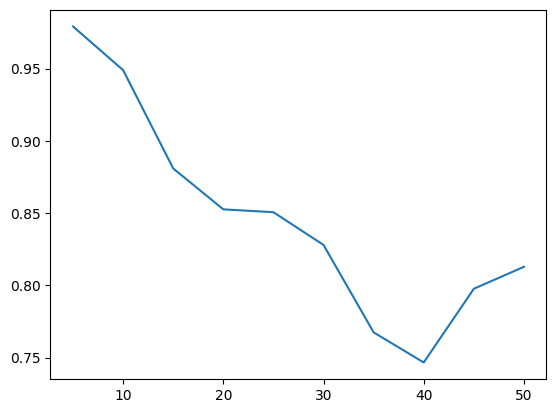

In [143]:
plt.plot(n_range, clf_gs.cv_results_['mean_test_score'])


### Randomized Search

In [144]:
clf_rs = RandomizedSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='accuracy')
clf_rs.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(),
                   param_distributions=[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}],
                   scoring='accuracy')

In [145]:
clf_rs.best_score_, clf_rs.best_params_


(0.9791913746630726, {'n_neighbors': 5})

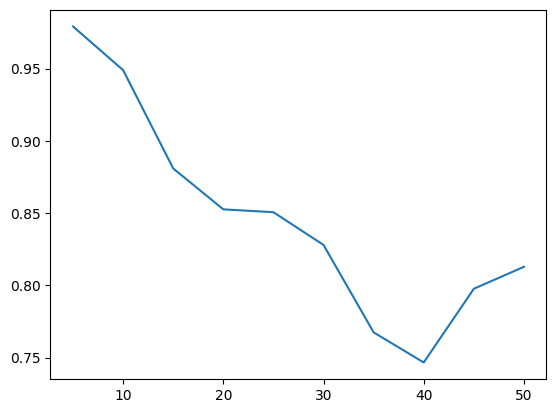

In [146]:
plt.plot(n_range, clf_rs.cv_results_['mean_test_score'])


## Построение кривых обучения и валидации

In [147]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.3,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'd:\\st\\семестр 6\\тмо\\лр\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

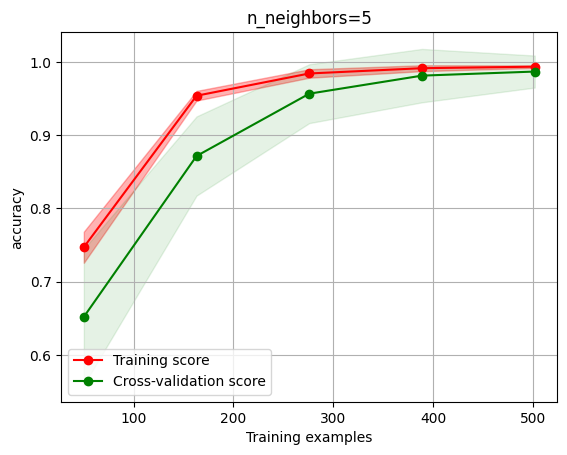

In [148]:
plot_learning_curve(KNeighborsClassifier(n_neighbors=5), 'n_neighbors=5', 
                    x_train, y_train, cv=20)

### Построение кривой валидации

In [149]:
def plot_validation_curve(estimator, title, X, y, 
                          param_name, param_range, cv, 
                          scoring='accuracy'):
                                                   
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel(str(scoring))
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.4,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'd:\\st\\семестр 6\\тмо\\лр\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

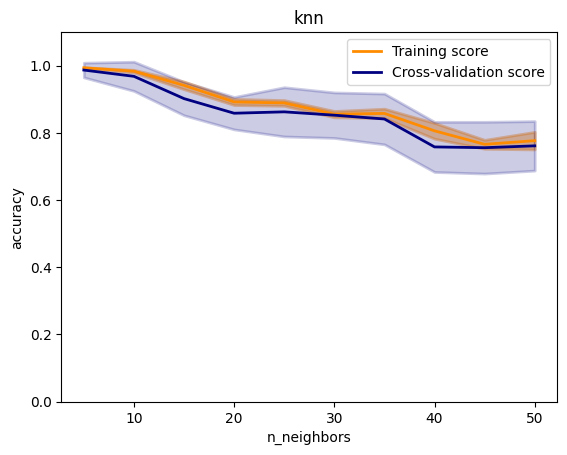

In [150]:
n_range = np.array(range(5,55,5))

plot_validation_curve(KNeighborsClassifier(), 'knn', 
                      x_train, y_train, 
                      param_name='n_neighbors', param_range=n_range, 
                      cv=20, scoring="accuracy")

In [151]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))


In [152]:
print_accuracy_score_for_classes(y_test, target1_1)


Метка 	 Accuracy
high 	 0.9841269841269841
low 	 0.995475113122172
medium 	 0.9890710382513661
